## Ultimate riders retention challenge

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
riders = pd.read_json('ultimate_data_challenge.json')
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [3]:
riders.head(5)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
# Add "active_rider" column if a rider took a trip after the first 30 days.  
riders['signup_date'] = pd.to_datetime(riders['signup_date'])
riders['last_trip_date'] = pd.to_datetime(riders['last_trip_date'])
riders['active_rider'] = ((riders['last_trip_date'] - riders['signup_date']).dt.days > 30).astype(int)

In [5]:
riders.active_rider.value_counts()

1    36973
0    13027
Name: active_rider, dtype: int64

In [6]:
print(f"About {(36973/50000)*100}% of riders are retained after the first 30 days.")

About 73.946% of riders are retained after the first 30 days.


### Data Cleaning

In [7]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  active_rider            50000 non-null  int32 

In [8]:
# Impute missing rating values with mean
riders['avg_rating_of_driver'].fillna(value=riders['avg_rating_of_driver'].mean(), inplace=True)
riders['avg_rating_by_driver'].fillna(value=riders['avg_rating_by_driver'].mean(), inplace=True)

In [9]:
# Drop the rows with missing values in 'phone' column
riders.dropna(inplace=True)

### Exploratory Data Analysis

#### Categorical variables

In [10]:
riders.city.value_counts()

Winterfell        23125
Astapor           16413
King's Landing    10066
Name: city, dtype: int64

In [11]:
riders.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

<AxesSubplot:xlabel='active_rider', ylabel='count'>

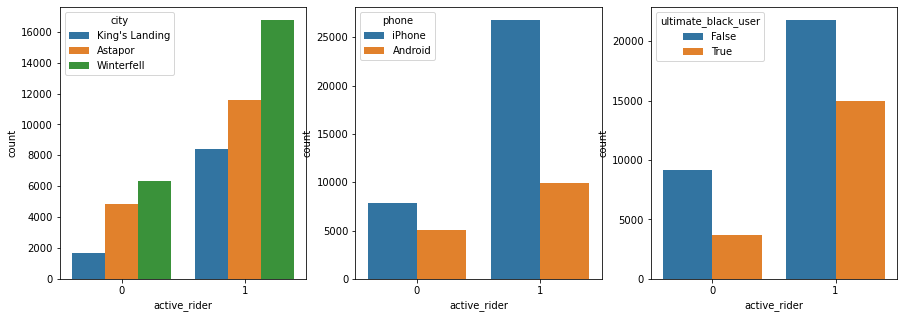

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.countplot(x='active_rider', hue='city', data=riders, ax=axes[0])
sns.countplot(x='active_rider', hue='phone', data=riders, ax=axes[1])
sns.countplot(x='active_rider', hue='ultimate_black_user', data=riders, ax=axes[2])

#### Numerical variables

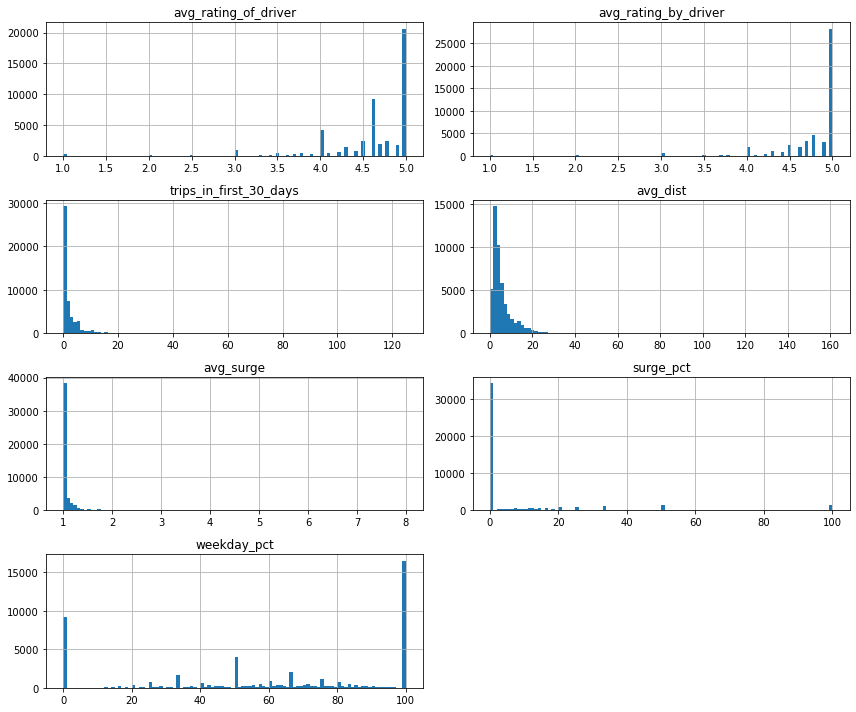

In [13]:
fig, axes = plt.subplots(4, 2, figsize=(12, 10))
fig.delaxes(axes[3,1])

riders.hist(column='avg_rating_of_driver', bins=100, ax=axes[0,0])
riders.hist(column='avg_rating_by_driver', bins=100, ax=axes[0,1])
riders.hist(column='trips_in_first_30_days', bins=100, ax=axes[1,0])
riders.hist(column='avg_dist', bins=100, ax=axes[1,1])
riders.hist(column='avg_surge', bins=100, ax=axes[2,0])
riders.hist(column='surge_pct', bins=100, ax=axes[2,1])
riders.hist(column='weekday_pct', bins=100, ax=axes[3,0])

plt.tight_layout()
plt.show()

#### Target variable

<AxesSubplot:xlabel='active_rider', ylabel='count'>

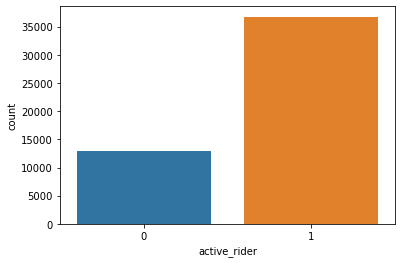

In [14]:
sns.countplot(x=riders.active_rider)

The dataset is imbalanced.

### Build predictive model

In [15]:
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

In [16]:
# Prepare the train and test datasets
X = riders[['city', 'trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'phone', 'surge_pct', 
            'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']]
y = riders['active_rider']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

In [17]:
# Create categorical encoder for the categorial variables
cat_cols = ['city', 'phone', 'ultimate_black_user']
encoder = ce.OneHotEncoder(cols=cat_cols, handle_unknown='return_nan', return_df=True, use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

C:\Users\c_lin\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [18]:
# Build a Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train_encoded, y_train)
pred = rf.predict(X_test_encoded)
prob_1 = rf.predict_proba(X_test_encoded)[:, 1]

accuracy = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, prob_1)
cm = confusion_matrix(y_test, pred)

print(f"The model accuracy score is {accuracy}")
print(f"The model ROC AUC score is {auc}")
print(f"Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_test, pred))

The model accuracy score is 0.9019252091523032
The model ROC AUC score is 0.9574626142549372
Confusion matrix:
 [[2028  545]
 [ 428 6920]]

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      2573
           1       0.93      0.94      0.93      7348

    accuracy                           0.90      9921
   macro avg       0.88      0.86      0.87      9921
weighted avg       0.90      0.90      0.90      9921



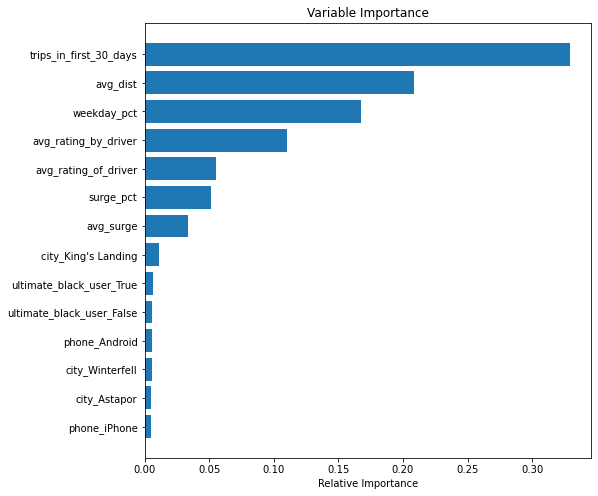

In [19]:
# Feature importance relative to max importance
feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(8,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_encoded.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

For this binary classification problem, I considered using SVM, KNN, Logistic Regression and Random Forest algorithms.  I picked the Random Forest algorithm for it tends to handle imbalanced datasets and outliers well.  It is also useful for feature importance extraction.  The model shows the top three important features are trips in the first 30 days, average distance of a trip and the percent of the user's trips occurring during a weekday.  In the future, Ultimate Inc. shall think about how to market to the riders to make more trips in the first 30 days.  It could be giving discounts to riders making longer trips or ride on a weekday.  